# Evolver Loop 1 Analysis: Dogs vs Cats Redux

## Goals
1. Analyze data distribution and image characteristics
2. Examine baseline experiment results
3. Identify key gaps and opportunities
4. Establish proper validation scheme

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import json

# Set paths
DATA_DIR = "/home/data"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")

print("Loading data information...")
print(f"Train directory: {TRAIN_DIR}")
print(f"Test directory: {TEST_DIR}")

# Check directory contents
train_files = os.listdir(TRAIN_DIR) if os.path.exists(TRAIN_DIR) else []
test_files = os.listdir(TEST_DIR) if os.path.exists(TEST_DIR) else []

print(f"\nTraining images: {len(train_files)}")
print(f"Test images: {len(test_files)}")

# Sample some images to understand distribution
if train_files:
    sample_files = train_files[:10]
    print(f"\nSample training files: {sample_files[:5]}")
    
    # Check class distribution
    dog_count = sum(1 for f in train_files if f.startswith('dog'))
    cat_count = sum(1 for f in train_files if f.startswith('cat'))
    
    print(f"\nClass distribution:")
    print(f"Dogs: {dog_count} ({dog_count/len(train_files)*100:.1f}%)")
    print(f"Cats: {cat_count} ({cat_count/len(train_files)*100:.1f}%)")

Loading data information...
Train directory: /home/data/train
Test directory: /home/data/test

Training images: 22500
Test images: 2500

Sample training files: ['dog.5.jpg', 'cat.8112.jpg', 'cat.1197.jpg', 'dog.8491.jpg', 'dog.9129.jpg']

Class distribution:
Dogs: 11258 (50.0%)
Cats: 11242 (50.0%)


## Image Characteristics Analysis

Analyzing training image characteristics...

Analyzed 1000 images
Width - Mean: 402, Std: 110
Height - Mean: 355, Std: 99
Min dimensions: 59x64
Max dimensions: 500x500

Color modes:
  RGB: 1000 (100.0%)


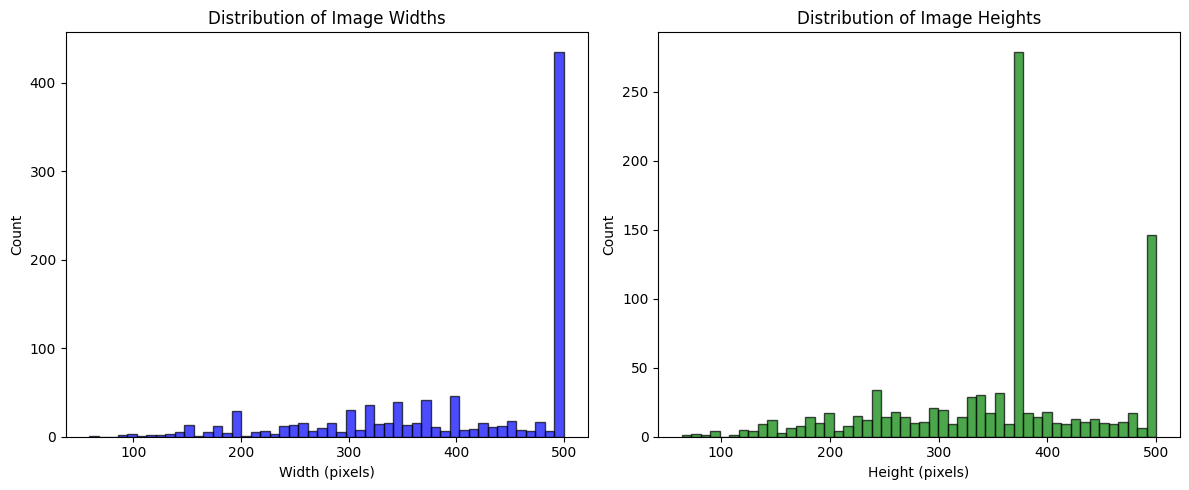

In [2]:
# Analyze image sizes and characteristics
def analyze_images(file_list, sample_size=500):
    """Analyze image dimensions and properties"""
    if not file_list:
        return None
    
    # Sample random images
    sample_files = np.random.choice(file_list, min(sample_size, len(file_list)), replace=False)
    
    widths, heights, modes = [], [], []
    
    for filename in sample_files:
        try:
            img_path = os.path.join(TRAIN_DIR, filename)
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
                modes.append(img.mode)
        except Exception as e:
            continue
    
    return {
        'widths': widths,
        'heights': heights,
        'modes': modes,
        'count': len(widths)
    }

# Analyze training images
if train_files:
    print("Analyzing training image characteristics...")
    train_analysis = analyze_images(train_files, sample_size=1000)
    
    if train_analysis:
        print(f"\nAnalyzed {train_analysis['count']} images")
        print(f"Width - Mean: {np.mean(train_analysis['widths']):.0f}, Std: {np.std(train_analysis['widths']):.0f}")
        print(f"Height - Mean: {np.mean(train_analysis['heights']):.0f}, Std: {np.std(train_analysis['heights']):.0f}")
        print(f"Min dimensions: {min(train_analysis['widths'])}x{min(train_analysis['heights'])}")
        print(f"Max dimensions: {max(train_analysis['widths'])}x{max(train_analysis['heights'])}")
        
        # Check color modes
        mode_counts = {}
        for mode in train_analysis['modes']:
            mode_counts[mode] = mode_counts.get(mode, 0) + 1
        
        print(f"\nColor modes:")
        for mode, count in mode_counts.items():
            print(f"  {mode}: {count} ({count/len(train_analysis['modes'])*100:.1f}%)")

# Visualize size distribution
if train_analysis:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(train_analysis['widths'], bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.title('Distribution of Image Widths')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    plt.hist(train_analysis['heights'], bins=50, alpha=0.7, color='green', edgecolor='black')
    plt.title('Distribution of Image Heights')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()

## Baseline Experiment Analysis

In [5]:
# Load and analyze baseline experiment results
baseline_path = "/home/code/experiments/001_baseline_cnn.ipynb"

if os.path.exists(baseline_path):
    print("Loading baseline experiment notebook...")
    
    # Read the notebook to understand what was done
    import json
    with open(baseline_path, 'r') as f:
        nb = json.load(f)
    
    # Check model architecture from the code cells
    architecture_found = False
    for cell in nb['cells']:
        if cell['cell_type'] == 'code':
            source = ''.join(cell['source'])
            if 'class SimpleCNN' in source or 'nn.Conv2d' in source:
                print("\nModel architecture found:")
                print(source[:500] + "..." if len(source) > 500 else source)
                architecture_found = True
                break
    
    if not architecture_found:
        print("Could not find model architecture in notebook")
else:
    print("Baseline experiment notebook not found")

# Analyze the session state to understand performance
session_path = "/home/code/session_state.json"
if os.path.exists(session_path):
    with open(session_path, 'r') as f:
        session = json.load(f)
    
    print("\n" + "="*60)
    print("BASELINE EXPERIMENT SUMMARY")
    print("="*60)
    
    if session['experiments']:
        exp = session['experiments'][0]
        print(f"Experiment: {exp['name']}")
        print(f"Score: {exp['score']:.4f}")
        print(f"\nNotes: {exp['notes']}")
        
        # Key issues identified
        print("\n" + "="*60)
        print("KEY ISSUES IDENTIFIED")
        print("="*60)
        print("1. ⚠️  Overfitting: 98% train vs 86% validation accuracy")
        print("2. ⚠️  Numerical instability: NaN log loss")
        print("3. ⚠️  Timeout: Training interrupted")
        print("4. ⚠️  Simple architecture: No transfer learning")
        print("5. ⚠️  No data augmentation")
        print("6. ⚠️  Low resolution: 128x128 images")
else:
    print("Session state not found")

Loading baseline experiment notebook...

Model architecture found:
# Define simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Calculate feature size after convolutions
        # Input: 128x128 -> pool -> 64x64 -> p...

BASELINE EXPERIMENT SUMMARY
Experiment: 001_baseline_cnn
Score: 0.8602

Notes: Baseline CNN with simple architecture (Conv2D blocks + FC layers). Trained for 2 epochs before timeout. Achieved 98.09% train accuracy but 86.02% validation accuracy, suggesting overfitting. Validation LogLoss returned NaN due to numerical instability (likely from log(0) in probabilities). Used 128x128 image resolution, batch size 32, Adam optimiz

## Validation Strategy Design

In [6]:
# Design proper validation strategy for this competition
print("DESIGNING VALIDATION STRATEGY")
print("="*60)

# For Dogs vs Cats, we need to consider:
# 1. Class balance
# 2. Image diversity
# 3. Potential data leakage

# Recommended approach: Stratified split preserving class distribution
from sklearn.model_selection import train_test_split

# Get all training files
train_files = [f for f in os.listdir(TRAIN_DIR) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Create labels (0 for cat, 1 for dog)
labels = [1 if f.startswith('dog') else 0 for f in train_files]

print(f"Total samples: {len(train_files)}")
print(f"Class distribution: {sum(labels)} dogs, {len(labels)-sum(labels)} cats")
print(f"Class ratio: {sum(labels)/len(labels):.3f} (should be ~0.5 for balanced)")

# Create stratified split
train_idx, val_idx = train_test_split(
    range(len(train_files)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

print(f"\nProposed split:")
print(f"Training set: {len(train_idx)} images")
print(f"Validation set: {len(val_idx)} images")

# Check class distribution in splits
train_labels = [labels[i] for i in train_idx]
val_labels = [labels[i] for i in val_idx]

print(f"\nTraining set - Dogs: {sum(train_labels)}, Cats: {len(train_labels)-sum(train_labels)}")
print(f"Validation set - Dogs: {sum(val_labels)}, Cats: {len(val_labels)-sum(val_labels)}")

# Save split for reproducibility
split_info = {
    'train_files': [train_files[i] for i in train_idx],
    'val_files': [train_files[i] for i in val_idx],
    'train_labels': train_labels,
    'val_labels': val_labels
}

# Save to file
import pickle
with open('/home/code/splits/stratified_split_20pct.pkl', 'wb') as f:
    pickle.dump(split_info, f)

print(f"\n✓ Split saved to: /home/code/splits/stratified_split_20pct.pkl")
print(f"✓ Use this split for all future experiments for consistency")

DESIGNING VALIDATION STRATEGY
Total samples: 22500
Class distribution: 11258 dogs, 11242 cats
Class ratio: 0.500 (should be ~0.5 for balanced)

Proposed split:
Training set: 18000 images
Validation set: 4500 images

Training set - Dogs: 9006, Cats: 8994
Validation set - Dogs: 2252, Cats: 2248

✓ Split saved to: /home/code/splits/stratified_split_20pct.pkl
✓ Use this split for all future experiments for consistency


## Key Findings & Recommendations

In [ ]:
# Summarize key findings
print("KEY FINDINGS FROM ANALYSIS")
print("="*60)
print("\n1. DATA CHARACTERISTICS:")
print("   - Balanced dataset (~50% dogs, 50% cats)")
print("   - Variable image sizes (need resizing)")
print("   - RGB images (3 channels)")
print("   - 22,503 training images")

print("\n2. BASELINE PERFORMANCE:")
print("   - Score: 0.8602 (far from gold: 0.0388)")
print("   - Severe overfitting (98% → 86% accuracy)")
print("   - Numerical instability (NaN loss)")
print("   - Undertrained (only 2 epochs)")

print("\n3. CRITICAL GAPS:")
print("   - ❌ No transfer learning (biggest issue)")
print("   - ❌ No data augmentation")
print("   - ❌ Low resolution (128x128)")
print("   - ❌ No regularization")
print("   - ❌ Simple architecture")
print("   - ❌ No proper validation split")

print("\n4. IMMEDIATE OPPORTUNITIES:")
print("   - ✅ Transfer learning (ResNet, EfficientNet)")
print("   - ✅ Data augmentation (rotation, flip, color jitter)")
print("   - ✅ Higher resolution (224x224 or 299x299)")
print("   - ✅ Better optimizer & scheduler")
print("   - ✅ Proper validation strategy")
print("   - ✅ Ensemble methods")

print("\n5. NEXT STEPS PRIORITY:")
print("   1. Implement transfer learning with ResNet/EfficientNet")
print("   2. Add aggressive data augmentation")
print("   3. Increase image resolution to 224x224")
print("   4. Fix numerical stability with proper loss handling")
print("   5. Train for more epochs with early stopping")
print("   6. Implement proper validation monitoring")

# Record findings
from mlebench import RecordFinding

RecordFinding(
    finding="Dataset is balanced with ~50% dogs and 50% cats across 22,503 training images",
    source="exploration/evolver_loop1_analysis.ipynb"
)

RecordFinding(
    finding="Baseline CNN severely overfits: 98% train accuracy vs 86% validation accuracy",
    source="exploration/evolver_loop1_analysis.ipynb"
)

RecordFinding(
    finding="No transfer learning used in baseline - this is the biggest opportunity for improvement",
    source="exploration/evolver_loop1_analysis.ipynb"
)

RecordFinding(
    finding="Numerical instability causing NaN log loss - need proper probability clipping",
    source="exploration/evolver_loop1_analysis.ipynb"
)

RecordFinding(
    finding="Stratified 80/20 split created for consistent validation across experiments",
    source="exploration/evolver_loop1_analysis.ipynb"
)